In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("183063h.csv")
df.drop(columns='Unnamed: 0',inplace=True)
df.head()

,avgMeasuredTime,avgSpeed,vehicleCount,Day sin,Day cos,Year sin,Year cos
0,94.333333,44.166667,37,1.305262e-01,-0.991445,0.684297,0.729203
1,104.750000,39.666667,99,5.591821e-12,-1.000000,0.684558,0.728958
2,111.333333,37.416667,136,-2.588190e-01,-0.965926,0.685081,0.728467
3,128.500000,32.083333,150,-5.000000e-01,-0.866025,0.685603,0.727976
4,107.250000,39.250000,125,-7.071068e-01,-0.707107,0.686124,0.727484


In [3]:
#Normalize the data
mean = df.mean()
std = df.std()
df = (df - mean) / std
df.head()

,avgMeasuredTime,avgSpeed,vehicleCount,Day sin,Day cos,Year sin,Year cos
0,-0.438201,0.164485,-0.208904,0.183409,-1.395105,0.742746,1.777563
1,0.153914,-0.389065,1.353849,-0.001508,-1.407180,0.743052,1.777070
2,0.528130,-0.665840,2.286459,-0.368176,-1.359085,0.743665,1.776081
3,1.503935,-1.321900,2.639339,-0.709857,-1.218078,0.744277,1.775092
4,0.296021,-0.440320,2.009197,-1.003265,-0.993768,0.744888,1.774102


In [4]:
def dnormal(x):return x*std.avgSpeed + mean.avgSpeed
mean.avgSpeed

42.829510785775696

In [5]:
#Split the data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.75)]        #75% train
val_df = df[int(n*0.75):int(n*0.9)] #15% validation
test_df = df[int(n*0.9):]           #10% test

num_features = df.shape[1]

In [6]:
model=tf.keras.models.load_model("lstmmodel5")

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [8]:
#Split
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [9]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [10]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result

  #print(result)
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [11]:
def plot(self, model=None, plot_col='avgSpeed', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))

  ppre=[]
  llabels=[]

  for n in range(max_n):
    print("n=",n)
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    
    llabels.append(labels[n, :, label_col_index])
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      ppre.append(predictions[n, :, label_col_index])
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [H]')

  return ppre,llabels

WindowGenerator.plot = plot

In [12]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=8,
    label_columns=['avgSpeed'])

wide_window

Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
Label column name(s): ['avgSpeed']

n= 0
n= 1
n= 2


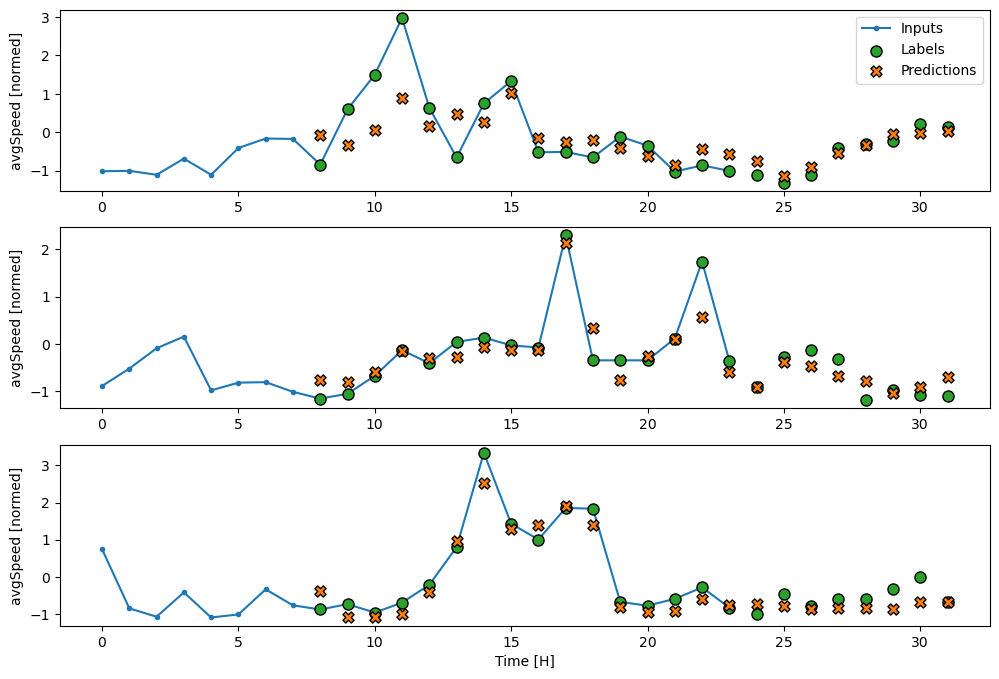

In [13]:
ppredictions,llabels=wide_window.plot(model)

In [14]:
pree=[]
for i in range(3):
    pree.append(pd.DataFrame({'label': llabels[i], 'predictions': ppredictions[i]}, columns=['label', 'predictions']))

pren2=dnormal(pree[1])

In [15]:
pren2.describe()

,label,predictions
count,24.000000,24.000000
mean,40.595139,40.272312
std,6.756056,5.385179
min,33.166664,34.466785
25%,35.333333,36.575163
50%,40.000000,39.401819
75%,42.295834,41.737465
max,61.500000,60.203346


In [16]:
pren2.label.max()

61.5

In [17]:
print("prediction de",len(pren2),"heure")
pren2.head()

prediction de 24 heure


,label,predictions
0,33.416664,36.580448
1,34.250000,36.296719
2,37.333332,37.965240
3,41.750000,41.636116
4,39.500000,40.428654


In [18]:
from traffic_signal import *
from road import *
from curve import *
from simulation import *
from vehicle import *
from vehicle_generator import *
from window import *
from simulation import Simulation
# Create simulation + data
sim = Simulation(pren2)
# Add multiple roads
sim.create_roads([
    ((-10, 108), (290, 108)),
    ((-10, 104), (290, 104)),

    ((290, 100), (-10, 100)),
    ((290, 96), (80, 96)),
    ((80, 96), (-10, 96)),
])
sim.create_gen({
    'vehicle_rate': 60,
    'vehicles': [
        [3, {"path": [0]}],
        [6, {"path": [1]}],
        
        [3, {"path": [3, 4]}],
        [6, {"path": [2]}],
    ]
})
# Start simulation
win = Window(sim)
win.offset = (-145, -95)
win.zoom = 8
win.run(steps_per_update=5)

pygame 2.2.0 (SDL 2.0.22, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html
self.vehicle_rate= 96
self.vehicle_rate= 93
self.vehicle_rate= 84
self.vehicle_rate= 71
self.vehicle_rate= 78
self.vehicle_rate= 67
self.vehicle_rate= 64
self.vehicle_rate= 68
self.vehicle_rate= 69
